# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import tensorflow as tf

print (tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Change current working directory to project folder (1 mark)

In [3]:
import os
os.chdir('.')
print (os.curdir)

.


### Load the "images.npy" file (4 marks)
- This file contains images with details of bounding boxes

In [4]:
import numpy as np
data = np.load('images.npy', allow_pickle=True)
print (len (data))

409


### Check one sample from the loaded "images.npy" file  (4 marks)

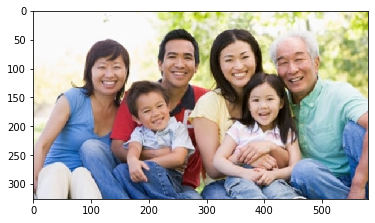

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.5586206896551724, 'y': 0.19938650306748465}, {'x': 0.6603448275862069, 'y': 0.3773006134969325}], 'imageWidth': 580, 'imageHeight': 326}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.38620689655172413, 'y': 0.18711656441717792}, {'x': 0.4896551724137931, 'y': 0.4049079754601227}], 'imageWidth': 580, 'imageHeight': 326}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.1724137931034483, 'y': 0.23006134969325154}, {'x': 0.2775862068965517, 'y': 0.44171779141104295}], 'imageWidth': 580, 'imageHeight': 326}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.7155172413793104, 'y': 0.19938650306748465}, {'x': 0.8448275862068966, 'y': 0.41411042944785276}], 'imageWidth': 580, 'imageHeight': 326}, {'label': ['Face'], 'notes': '', 'points': [{'x': 0.2982758620689655, 'y': 0.44171779141104295}, {'x': 0.4189655172413793, 'y': 0.6533742331288344}], 'imageWidth': 580, 'imageHeight': 326}, {'label': ['Face'], 'notes': '', 'points': [{'

In [5]:
import matplotlib.pyplot as plt

plt.imshow(data[4,0])
plt.show()

print (data[4,1])

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [6]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [106]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [107]:
#### Add your code here ####
print (X_train.shape)
print (masks.shape)

(409, 224, 224, 3)
(409, 224, 224)


### Print a sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


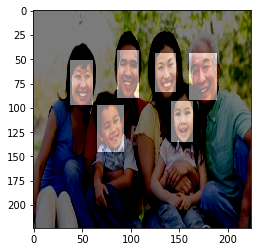

In [108]:
from matplotlib import pyplot
n = 4
pyplot.imshow(X_train[n])
pyplot.imshow(masks[n,:, :], cmap='gray', alpha=0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


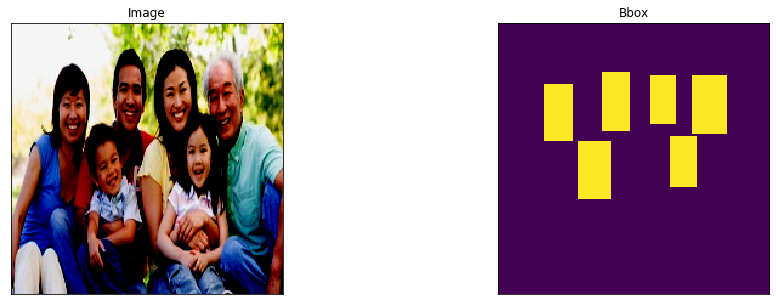

In [109]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
visualize(image = X_train[n],
         bbox = masks[n]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


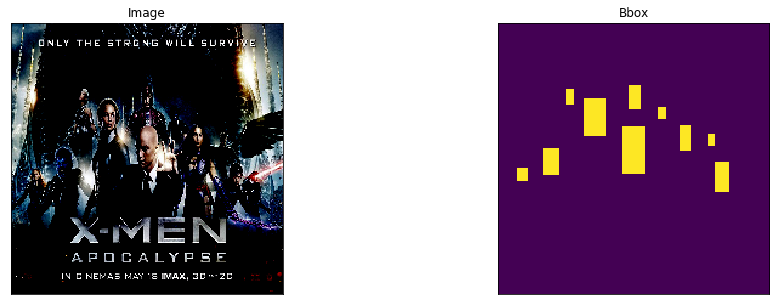

In [110]:
test_image = X_train[408]
test_mask = masks[408]

visualize(image = test_image,
         bbox = test_mask)

X_train = X_train[0:407]
masks = masks[0:407]

In [111]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def data_generator(x_train, y_train, batch_size):
    """
    Function to implement data augmentation
    
    Parameters
    ----------
    x_train : numpy array of raw images
    y_train : numpy array of mask images
    batch_size : integer value that specifies batch size 
    
    Returns
    -------
    x_batch, y_bathc : Image Generators
    
    """
    data_gen_args = dict(width_shift_range = 0.1,
            height_shift_range = 0.1,
            rotation_range = 10,
            horizontal_flip=True,
            zoom_range = 0.1)
    
    #**data_gen_args
    
    image_generator = ImageDataGenerator(**data_gen_args).flow(x_train, 
                                               x_train, 
                                               batch_size, 
                                               seed = 42)
    
    mask_generator = ImageDataGenerator(**data_gen_args).flow(y_train, 
                                              y_train, 
                                              batch_size, 
                                              seed = 42)
    
    while True:
        x_batch, _ = image_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [112]:
from sklearn.model_selection import train_test_split

masks = masks.reshape((masks.shape[0],masks.shape[1],masks.shape[2],1))
x_train, x_val, y_train, y_val = train_test_split(X_train, masks, test_size = 0.1)

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient

Good explanation available at https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2


In [14]:
def dice_coefficient(y_true, y_pred):
    """
    Function to calculate dice coefficient
    
    Parameters
    ----------
    y_true : numpy array of actual masks
    y_pred : numpy array of predicted masks
    
    Returns
    -------
    dice coefficient
    
    """
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + epsilon())

### Define loss

In [15]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

def loss(y_true, y_pred):    
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())
    #return binary_crossentropy(y_true, y_pred)

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [16]:
#!pip install git+https://github.com/tensorflow/examples.git

In [65]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Concatenate, Conv2D, Conv2DTranspose, UpSampling2D, Dropout, Reshape, BatchNormalization, Activation
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import epsilon
from tensorflow.keras.models import Model
from tensorflow_examples.models.pix2pix import pix2pix

ALPHA = 1.0

def create_model(trainable):
    model = MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), 
                        include_top=False, 
                        alpha=ALPHA, 
                        weights="imagenet")
    
    model.trainable = False
    
    for layer in model.layers[155:]:
        layer.trainable = trainable
        
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    
    block0 = model.get_layer("block_1_expand_relu").output
    block1 = model.get_layer("block_3_expand_relu").output
    block2 = model.get_layer("block_6_expand_relu").output
    block3 = model.get_layer("block_13_expand_relu").output
    block4 = model.get_layer("block_16_project").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block0])
    x = UpSampling2D()(x)
    
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)    

### Call the create_model function

In [134]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(True)

# Print summary
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_18[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
___________________________________________________________________________________________

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

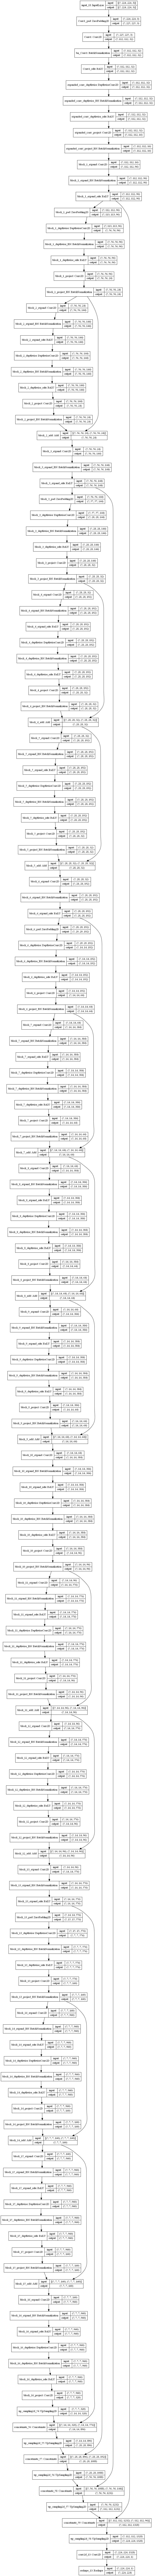

In [135]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[dice_coefficient,'accuracy'])
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics=['accuracy',dice_coefficient])

tf.keras.utils.plot_model(model, show_shapes=True)

### Define checkpoint and earlystopping

In [136]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", 
                             monitor="val_loss", 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True, 
                             mode="min", 
                             period=1)

stop = EarlyStopping(monitor="val_loss", 
                     patience=10, 
                     mode="min")

reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                              factor=0.2, 
                              patience=3, 
                              min_lr=1e-9, 
                              verbose=1, 
                              mode="min")



### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [137]:
EPOCHS = 20
STEPS_PER_EPOCH = x_train.shape[0]
VAL_SUBSPLITS = 5
VAL_STEPS_PER_EPOCH = x_val.shape[0]/VAL_SUBSPLITS
BATCH_SIZE = 1

history = model.fit_generator(data_generator(x_train,y_train,BATCH_SIZE),
                              steps_per_epoch = STEPS_PER_EPOCH,
                              validation_data = (x_val,y_val),
                              #validation_steps = VAL_STEPS_PER_EPOCH,
                              epochs=EPOCHS,
                              callbacks=[checkpoint, reduce_lr, stop])

  ...
    to  
  ['...']
Train for 366 steps, validate on 41 samples
Epoch 1/20
363/366 [============================>.] - ETA: 0s - loss: 2.0147 - accuracy: 0.0071 - dice_coefficient: 0.2394- ETA: 2s - loss: 2.1366 - accuracy: 0.00
Epoch 00001: val_loss improved from inf to 1.69033, saving model to model-1.69.h5
366/366 [==============================] - 11s 31ms/step - loss: 2.0121 - accuracy: 0.0071 - dice_coefficient: 0.2395 - val_loss: 1.6903 - val_accuracy: 0.0024 - val_dice_coefficient: 0.2879
Epoch 2/20
363/366 [============================>.] - ETA: 0s - loss: 1.5001 - accuracy: 0.0080 - dice_coefficient: 0.3378- ETA: 5s - loss: 1.6562 - accuracy: 0.0109 - dice - ETA: 4s - loss: 1.6074 - accu - ETA: 1s - loss: 1.5268 - accuracy: 0.008
Epoch 00002: val_loss improved from 1.69033 to 1.46413, saving model to model-1.46.h5
366/366 [==============================] - 8s 22ms/step - loss: 1.5022 - accuracy: 0.0079 - dice_coefficient: 0.3373 - val_loss: 1.4641 - val_accuracy: 0.0028 -

Epoch 20/20
364/366 [============================>.] - ETA: 0s - loss: 1.0598 - accuracy: 0.0033 - dice_coefficient: 0.5008
Epoch 00020: val_loss did not improve from 1.08001
366/366 [==============================] - 8s 22ms/step - loss: 1.0584 - accuracy: 0.0033 - dice_coefficient: 0.5012 - val_loss: 1.0983 - val_accuracy: 0.0028 - val_dice_coefficient: 0.4917


dict_keys(['loss', 'accuracy', 'dice_coefficient', 'val_loss', 'val_accuracy', 'val_dice_coefficient', 'lr'])


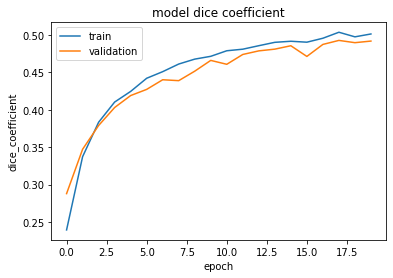

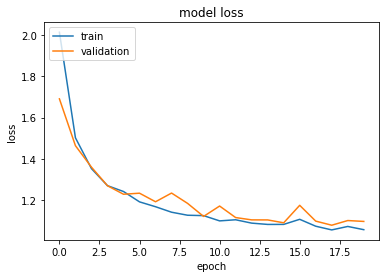

In [138]:
def plot_model_history(history):
    """
    Function to plot training and validation data of model
    
    Parameters
    ----------
    history: dictionary
             history of training and validation of model
    Returns
    -------
    None
    
    """
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['dice_coefficient'])
    plt.plot(history.history['val_dice_coefficient'])
    plt.title('model dice coefficient')
    plt.ylabel('dice_coefficient')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
plot_model_history(history)    

### Get the predicted mask for a sample image   (5 marks)

In [139]:
model = create_model(True)
model.load_weights('model-1.66.h5')

In [150]:
#### Add your code here ####
from skimage.io import imread

test_image_orig = test_image

feat_scaled = preprocess_input(np.array(test_image_orig, dtype=np.float32))
region = model.predict(x=np.array([feat_scaled]))[0]

### Impose the mask on the image (5 marks)

In [141]:
THRESHOLD = .7
EPSILON = 0.01

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

output = np.zeros(test_image.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > THRESHOLD:
            x = int(CELL_WIDTH * j * test_image.shape[1] / IMAGE_WIDTH)
            y = int(CELL_HEIGHT * i * test_image.shape[0] / IMAGE_HEIGHT)
            x2 = int(CELL_WIDTH * (j + 1) * test_image.shape[1] / IMAGE_WIDTH)
            y2 = int(CELL_HEIGHT * (i + 1) * test_image.shape[0] / IMAGE_HEIGHT)
            #cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)

            output[y:y2,x:x2] = 1

contours, _ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    
    approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    print (x,y,w,h)
    cv2.rectangle(test_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

cv2.imshow("image", test_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Model 2:
    In this model I tried to unfreeze the layers which I am using in upsampling. While the dice coeffecient came high the generated mask wasn't great

In [17]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Concatenate, Conv2D, Conv2DTranspose, UpSampling2D, Dropout, Reshape, BatchNormalization, Activation
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import epsilon
from tensorflow.keras.models import Model
from tensorflow_examples.models.pix2pix import pix2pix

ALPHA = 1.0

def create_down_stack(trainable):
    base_model = MobileNetV2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), 
                        include_top=False, 
                        alpha=ALPHA, 
                        weights="imagenet")
    
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    
    layers = [base_model.get_layer(name).output for name in layer_names]
    
    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = trainable
    
    return down_stack

def create_model_1(trainable=True):
    
    up_stack = [
        pix2pix.upsample(224, 3),  # 7x7 -> 14x14
        pix2pix.upsample(112, 3),  # 14x14 -> 28x28
        pix2pix.upsample(56, 3),  # 28x28 -> 56x56
        pix2pix.upsample(28, 3),   # 56x56 -> 112x112
        pix2pix.upsample(14, 3),   # 112x112 -> 224x224
    ]
    
    inputs = tf.keras.layers.Input(shape=[224, 224, 3])
    x = inputs
    
    down_stack = create_down_stack(trainable)
    
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(2, 3, strides=2, padding='same')  #64x64 -> 128x128
    x = last(x)  
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((224, 224))(x)
    print ('Final layer after convolution->',x)

    return Model(inputs=inputs, outputs=x)

# Model 3:
    This is a custom model which i was trying to replicate the UNet architecture

In [26]:
def modelBuilder():
    """
    Function to build and train the UNet model
    
    Parameters
    ----------
    x_train : numpy array of training images
    y_train : numpy array of training masks
    x_val : numpy array of validation images
    y_val : numpy array of validation masks
    
    Returns
    -------
    model : Trained model
    results : Dictionary of model metrics
    
    """
    print ('Building U-Net...')
    inputs = tf.keras.layers.Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(s)
    conv1 = tf.keras.layers.Dropout(0.1)(conv1)
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool1)
    conv2 = tf.keras.layers.Dropout(0.1)(conv2)
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool2)
    conv3 = tf.keras.layers.Dropout(0.2)(conv3)
    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool3)
    conv4 = tf.keras.layers.Dropout(0.2)(conv4)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(pool4)
    conv5 = tf.keras.layers.Dropout(0.3)(conv5)
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv5)

    upconv6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    upconv6 = tf.keras.layers.concatenate([upconv6, conv4])
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv6)
    conv6 = tf.keras.layers.Dropout(0.2)(conv6)
    conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv6)

    upconv7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    upconv7 = tf.keras.layers.concatenate([upconv7, conv3])
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv7)
    conv7 = tf.keras.layers.Dropout(0.2)(conv7)
    conv7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv7)

    upconv8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    upconv8 = tf.keras.layers.concatenate([upconv8, conv2])
    conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv8)
    conv8 = tf.keras.layers.Dropout(0.1)(conv8)
    conv8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv8)

    upconv9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    upconv9 = tf.keras.layers.concatenate([upconv9, conv1], axis=3)
    conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(upconv9)
    conv9 = tf.keras.layers.Dropout(0.1)(conv9)
    conv9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                                padding='same')(conv9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model